In [1]:
#https://github.com/adventuresinML/adventures-in-ml-code/blob/master/keras_lstm.py
    
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np

# for scaling and inverse_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
from keras.models import load_model

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger

import pickle
from os import listdir

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	print(type(data))
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # range([start,] stop [, step])
        # DataFrame.shift(periods=1, freq=None, axis=0), returns DataFrame
		cols.append(df.shift(i)) 
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	# We are only interested in final bb after certain frames, e.g. 31st, 61st etc
	for i in range(n_out - 1 , n_out): #(n_out th element from the last element in the sequence)
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    #  concatenating along the columns (axis=1), a DataFrame is returned.
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
pickle_in = open("min-max-scaler.pkl","rb")
scaler = pickle.load(pickle_in)
print(scaler.data_max_)
print(scaler.data_min_)

[1900.  953. 1919. 1079.]
[0. 0. 0. 0.]


In [2]:
# load dataset
dataset = read_csv('bb-cross-train.csv', header=0)
values = dataset.values
print(values.shape)

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaler.data_max_)
print(scaler.data_min_)

pickle.dump(scaler, open("min-max-scaler.pkl", 'wb'))

# specify the number of lag hours
n_seq = 30
n_seq_future = 30
n_features = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_seq, n_seq_future)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_num = 84372 - 20000
train = values[:n_train_num, :]
val = values[n_train_num:, :]

# split into input and outputs
n_obs = n_seq * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:n_obs+n_features]
val_X, val_y = val[:, :n_obs], val[:, n_obs:n_obs+n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_seq, n_features))
val_X = val_X.reshape((val_X.shape[0], n_seq, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)


(84371, 4)
[1900.  953. 1919. 1079.]
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
(84312, 124)
(64372, 120) 64372 (64372, 4)
(64372, 30, 4) (64372, 4) (19940, 30, 4) (19940, 4)


In [2]:
train_csv = ["train/%s" %f for f in listdir("./train")]
#print(train_csv)

In [3]:
#del reframed
reframed = np.zeros( (1,124) )

In [4]:
(reframed[0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [5]:
# specify the number of lag hours
n_seq = 30
n_seq_future = 30
n_features = 4
np.array(reframed, dtype='float32')
# load dataset
#train_csv = ["train/0_184_1327b.csv", "train/0_184_1329b.csv"]
for f in train_csv:
    dataset = read_csv(f, header=0)
    values = dataset.values
    print(values.shape)

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    #print(scaler.data_max_)
    #print(scaler.data_min_)

    # frame as supervised learning
    reframed = np.append(reframed, series_to_supervised(scaled, n_seq, n_seq_future), axis = 0)
    print(reframed.shape)
reframed = np.delete(reframed, 0, axis = 0)
print(reframed.shape)
# split into train and test sets
values = reframed
print(values.shape)
n_train_num = int(reframed.shape[0] * 0.8)
print(n_train_num)
train = values[:n_train_num, :]
val = values[n_train_num:, :]

# split into input and outputs
n_obs = n_seq * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:n_obs+n_features]
val_X, val_y = val[:, :n_obs], val[:, n_obs:n_obs+n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_seq, n_features))
val_X = val_X.reshape((val_X.shape[0], n_seq, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(284, 4)
<class 'numpy.ndarray'>
(226, 124)
(84, 4)
<class 'numpy.ndarray'>
(251, 124)
(273, 4)
<class 'numpy.ndarray'>
(465, 124)
(119, 4)
<class 'numpy.ndarray'>
(525, 124)
(170, 4)
<class 'numpy.ndarray'>
(636, 124)
(113, 4)
<class 'numpy.ndarray'>
(690, 124)
(239, 4)
<class 'numpy.ndarray'>
(870, 124)
(149, 4)
<class 'numpy.ndarray'>
(960, 124)
(330, 4)
<class 'numpy.ndarray'>
(1231, 124)
(144, 4)
<class 'numpy.ndarray'>
(1316, 124)
(149, 4)
<class 'numpy.ndarray'>
(1406, 124)
(289, 4)
<class 'numpy.ndarray'>
(1636, 124)
(293, 4)
<class 'numpy.ndarray'>
(1870, 124)
(175, 4)
<class 'numpy.ndarray'>
(1986, 124)
(239, 4)
<class 'numpy.ndarray'>
(2166, 124)
(179, 4)
<class 'numpy.ndarray'>
(2286, 124)
(299, 4)
<class 'numpy.ndarray'>
(2526, 124)
(239, 4)
<class 'numpy.ndarray'>
(2706, 124)
(149, 4)
<class 'numpy.ndarray'>
(2796, 124)
(107, 4)
<class 'numpy.ndarray'>
(2844, 124)
(209, 4)
<class 'numpy.ndarray'>
(2994, 124)
(237, 4)
<class 'numpy.ndarray'>
(3172, 124)
(209, 4)
<class 'nu

(27687, 124)
(172, 4)
<class 'numpy.ndarray'>
(27800, 124)
(149, 4)
<class 'numpy.ndarray'>
(27890, 124)
(160, 4)
<class 'numpy.ndarray'>
(27991, 124)
(174, 4)
<class 'numpy.ndarray'>
(28106, 124)
(149, 4)
<class 'numpy.ndarray'>
(28196, 124)
(119, 4)
<class 'numpy.ndarray'>
(28256, 124)
(149, 4)
<class 'numpy.ndarray'>
(28346, 124)
(149, 4)
<class 'numpy.ndarray'>
(28436, 124)
(239, 4)
<class 'numpy.ndarray'>
(28616, 124)
(149, 4)
<class 'numpy.ndarray'>
(28706, 124)
(281, 4)
<class 'numpy.ndarray'>
(28928, 124)
(206, 4)
<class 'numpy.ndarray'>
(29075, 124)
(209, 4)
<class 'numpy.ndarray'>
(29225, 124)
(179, 4)
<class 'numpy.ndarray'>
(29345, 124)
(269, 4)
<class 'numpy.ndarray'>
(29555, 124)
(231, 4)
<class 'numpy.ndarray'>
(29727, 124)
(182, 4)
<class 'numpy.ndarray'>
(29850, 124)
(118, 4)
<class 'numpy.ndarray'>
(29909, 124)
(149, 4)
<class 'numpy.ndarray'>
(29999, 124)
(242, 4)
<class 'numpy.ndarray'>
(30182, 124)
(495, 4)
<class 'numpy.ndarray'>
(30618, 124)
(239, 4)
<class 'nump

(53489, 124)
(119, 4)
<class 'numpy.ndarray'>
(53549, 124)
(146, 4)
<class 'numpy.ndarray'>
(53636, 124)
(239, 4)
<class 'numpy.ndarray'>
(53816, 124)
(149, 4)
<class 'numpy.ndarray'>
(53906, 124)
(118, 4)
<class 'numpy.ndarray'>
(53965, 124)
(150, 4)
<class 'numpy.ndarray'>
(54056, 124)
(234, 4)
<class 'numpy.ndarray'>
(54231, 124)
(158, 4)
<class 'numpy.ndarray'>
(54330, 124)
(57, 4)
<class 'numpy.ndarray'>
(54330, 124)
(145, 4)
<class 'numpy.ndarray'>
(54416, 124)
(188, 4)
<class 'numpy.ndarray'>
(54545, 124)
(122, 4)
<class 'numpy.ndarray'>
(54608, 124)
(206, 4)
<class 'numpy.ndarray'>
(54755, 124)
(149, 4)
<class 'numpy.ndarray'>
(54845, 124)
(346, 4)
<class 'numpy.ndarray'>
(55132, 124)
(239, 4)
<class 'numpy.ndarray'>
(55312, 124)
(179, 4)
<class 'numpy.ndarray'>
(55432, 124)
(138, 4)
<class 'numpy.ndarray'>
(55511, 124)
(304, 4)
<class 'numpy.ndarray'>
(55756, 124)
(347, 4)
<class 'numpy.ndarray'>
(56044, 124)
(152, 4)
<class 'numpy.ndarray'>
(56137, 124)
(208, 4)
<class 'numpy

In [6]:
(train_X[0])

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 7.11267948e-01],
       [0.00000000e+00, 9.93630648e-01, 4.82573733e-03, 7.25352287e-01],
       [0.00000000e+00, 9.80891705e-01, 9.11528245e-03, 7.25352287e-01],
       [5.29661018e-04, 9.74522352e-01, 1.34048238e-02, 7.32394695e-01],
       [5.29661018e-04, 9.61783648e-01, 1.66219845e-02, 7.32394695e-01],
       [5.29661018e-04, 9.55414057e-01, 1.98391415e-02, 7.46479034e-01],
       [1.05932204e-03, 9.42675352e-01, 2.25201063e-02, 7.46479034e-01],
       [1.05932204e-03, 9.36305761e-01, 2.35924907e-02, 7.53521442e-01],
       [1.05932204e-03, 9.23567057e-01, 2.41286866e-02, 7.53521442e-01],
       [1.58898300e-03, 9.17197466e-01, 2.52010711e-02, 7.67605782e-01],
       [1.58898300e-03, 9.04458761e-01, 2.52010711e-02, 7.67605782e-01],
       [1.58898300e-03, 8.98089170e-01, 2.52010711e-02, 7.74648190e-01],
       [1.58898300e-03, 8.85350466e-01, 2.52010711e-02, 7.74648190e-01],
       [2.11864407e-03, 8.78980875e-01, 2.57372633e

In [7]:
train_y[0]

array([0.12182204, 0.77707005, 0.16032171, 0.78873253])

In [8]:
reframed.shape[0]

59594

In [9]:
print(reframed.shape)

(59594, 124)


In [10]:
train_X.shape

(47675, 30, 4)

In [11]:
val_X.shape

(11919, 30, 4)

In [13]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath='30f_future_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='bb_lstm_training_log.csv',
                       separator=',',
                       append=True)

#early_stopping = EarlyStopping(monitor='val_loss',
#                               min_delta=0.0,
#                               patience=20,
#                               verbose=1)

#reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
#                                         factor=0.2,
#                                         patience=8,
#                                         verbose=1,
#                                         epsilon=0.001,
#                                         cooldown=0,
#                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             csv_logger
#             early_stopping
             #reduce_learning_rate]
            ]

In [14]:
 # design network
K.clear_session()  # Clear previous models from memory.    
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(4))
#adam = optimizers.Adam(lr=0.01, decay=0.0001)
model.compile(loss='mae', optimizer="adam")
#A loss function or objective function, or optimization score function
#mean_absolute_error

epochs = 300
# fit network
history = model.fit(train_X, train_y, 
                    epochs=epochs, 
                    batch_size=16, 
                    validation_data=(val_X, val_y), 
                    verbose=2,
                    callbacks=callbacks,
                    shuffle=False)



Train on 47675 samples, validate on 11919 samples
Epoch 1/300
 - 160s - loss: 0.1649 - val_loss: 0.1459

Epoch 00001: val_loss improved from inf to 0.14588, saving model to 30f_future_epoch-01_loss-0.1649_val_loss-0.1459.h5
Epoch 2/300
 - 158s - loss: 0.1479 - val_loss: 0.1412

Epoch 00002: val_loss improved from 0.14588 to 0.14120, saving model to 30f_future_epoch-02_loss-0.1479_val_loss-0.1412.h5
Epoch 3/300
 - 157s - loss: 0.1395 - val_loss: 0.1272

Epoch 00003: val_loss improved from 0.14120 to 0.12715, saving model to 30f_future_epoch-03_loss-0.1395_val_loss-0.1272.h5
Epoch 4/300
 - 157s - loss: 0.1240 - val_loss: 0.1219

Epoch 00004: val_loss improved from 0.12715 to 0.12190, saving model to 30f_future_epoch-04_loss-0.1240_val_loss-0.1219.h5
Epoch 5/300
 - 157s - loss: 0.1215 - val_loss: 0.1189

Epoch 00005: val_loss improved from 0.12190 to 0.11888, saving model to 30f_future_epoch-05_loss-0.1215_val_loss-0.1189.h5
Epoch 6/300
 - 158s - loss: 0.1233 - val_loss: 0.1202

Epoch 000

 - 158s - loss: 0.0789 - val_loss: 0.0808

Epoch 00062: val_loss did not improve from 0.07983
Epoch 63/300
 - 158s - loss: 0.0788 - val_loss: 0.0783

Epoch 00063: val_loss improved from 0.07983 to 0.07826, saving model to 30f_future_epoch-63_loss-0.0788_val_loss-0.0783.h5
Epoch 64/300
 - 159s - loss: 0.0792 - val_loss: 0.0783

Epoch 00064: val_loss improved from 0.07826 to 0.07825, saving model to 30f_future_epoch-64_loss-0.0792_val_loss-0.0783.h5
Epoch 65/300
 - 159s - loss: 0.0787 - val_loss: 0.0783

Epoch 00065: val_loss did not improve from 0.07825
Epoch 66/300
 - 158s - loss: 0.0786 - val_loss: 0.0785

Epoch 00066: val_loss did not improve from 0.07825
Epoch 67/300
 - 159s - loss: 0.0792 - val_loss: 0.0771

Epoch 00067: val_loss improved from 0.07825 to 0.07708, saving model to 30f_future_epoch-67_loss-0.0792_val_loss-0.0771.h5
Epoch 68/300
 - 158s - loss: 0.0780 - val_loss: 0.0796

Epoch 00068: val_loss did not improve from 0.07708
Epoch 69/300
 - 160s - loss: 0.0783 - val_loss: 

 - 158s - loss: 0.0728 - val_loss: 0.0776

Epoch 00136: val_loss did not improve from 0.07681
Epoch 137/300
 - 160s - loss: 0.0727 - val_loss: 0.0784

Epoch 00137: val_loss did not improve from 0.07681
Epoch 138/300
 - 159s - loss: 0.0724 - val_loss: 0.0789

Epoch 00138: val_loss did not improve from 0.07681
Epoch 139/300
 - 160s - loss: 0.0728 - val_loss: 0.0789

Epoch 00139: val_loss did not improve from 0.07681
Epoch 140/300
 - 159s - loss: 0.0722 - val_loss: 0.0770

Epoch 00140: val_loss did not improve from 0.07681
Epoch 141/300
 - 159s - loss: 0.0724 - val_loss: 0.0783

Epoch 00141: val_loss did not improve from 0.07681
Epoch 142/300
 - 160s - loss: 0.0720 - val_loss: 0.0784

Epoch 00142: val_loss did not improve from 0.07681
Epoch 143/300
 - 159s - loss: 0.0723 - val_loss: 0.0769

Epoch 00143: val_loss did not improve from 0.07681
Epoch 144/300
 - 159s - loss: 0.0724 - val_loss: 0.0771

Epoch 00144: val_loss did not improve from 0.07681
Epoch 145/300
 - 159s - loss: 0.0722 - val

 - 158s - loss: 0.0690 - val_loss: 0.0789

Epoch 00209: val_loss did not improve from 0.07476
Epoch 210/300
 - 159s - loss: 0.0684 - val_loss: 0.0795

Epoch 00210: val_loss did not improve from 0.07476
Epoch 211/300
 - 159s - loss: 0.0688 - val_loss: 0.0803

Epoch 00211: val_loss did not improve from 0.07476
Epoch 212/300
 - 159s - loss: 0.0682 - val_loss: 0.0805

Epoch 00212: val_loss did not improve from 0.07476
Epoch 213/300
 - 158s - loss: 0.0681 - val_loss: 0.0802

Epoch 00213: val_loss did not improve from 0.07476
Epoch 214/300
 - 158s - loss: 0.0680 - val_loss: 0.0804

Epoch 00214: val_loss did not improve from 0.07476
Epoch 215/300
 - 158s - loss: 0.0681 - val_loss: 0.0787

Epoch 00215: val_loss did not improve from 0.07476
Epoch 216/300
 - 159s - loss: 0.0677 - val_loss: 0.0768

Epoch 00216: val_loss did not improve from 0.07476
Epoch 217/300
 - 158s - loss: 0.0678 - val_loss: 0.0808

Epoch 00217: val_loss did not improve from 0.07476
Epoch 218/300
 - 158s - loss: 0.0678 - val

 - 156s - loss: 0.0651 - val_loss: 0.0801

Epoch 00285: val_loss did not improve from 0.07476
Epoch 286/300
 - 157s - loss: 0.0647 - val_loss: 0.0833

Epoch 00286: val_loss did not improve from 0.07476
Epoch 287/300
 - 157s - loss: 0.0644 - val_loss: 0.0829

Epoch 00287: val_loss did not improve from 0.07476
Epoch 288/300
 - 156s - loss: 0.0647 - val_loss: 0.0806

Epoch 00288: val_loss did not improve from 0.07476
Epoch 289/300
 - 158s - loss: 0.0650 - val_loss: 0.0810

Epoch 00289: val_loss did not improve from 0.07476
Epoch 290/300
 - 160s - loss: 0.0645 - val_loss: 0.0825

Epoch 00290: val_loss did not improve from 0.07476
Epoch 291/300
 - 160s - loss: 0.0649 - val_loss: 0.0825

Epoch 00291: val_loss did not improve from 0.07476
Epoch 292/300
 - 157s - loss: 0.0648 - val_loss: 0.0803

Epoch 00292: val_loss did not improve from 0.07476
Epoch 293/300
 - 156s - loss: 0.0647 - val_loss: 0.0812

Epoch 00293: val_loss did not improve from 0.07476
Epoch 294/300
 - 156s - loss: 0.0640 - val

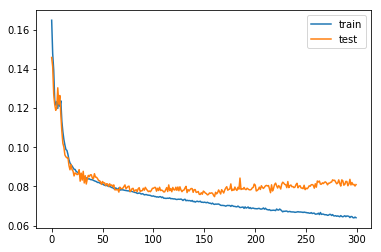

In [15]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig("30f_future.png")
pyplot.show()


In [16]:
# save the model
model.save("30f_future-model.h5")

In [10]:
# load test dataset
values = read_csv('bb-cross-test1.csv', header=0).values
print(len(values))
# ensure all data is float
values = values.astype('float32')

# normalize features

scaled = scaler.transform(values)
print(scaler.data_max_)
print(scaler.data_min_)

# specify the number of lag hours
#n_seq = 15
#n_features = 4

# frame as supervised learning
reframed = series_to_supervised(scaled, n_seq, 1)
print(reframed.shape)
values = reframed.values

# split into input and outputs
n_obs = n_seq * n_features
test_X, test_y = values[:, :n_obs], values[:, n_obs:n_obs+n_features]
print(test_X.shape, len(test_X), test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], n_seq, n_features))
print(test_X.shape, test_y.shape)

204
[1900.  953. 1919. 1079.]
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
(173, 124)
(173, 120) 173 (173, 4)
(173, 30, 4) (173, 4)


In [23]:
K.clear_session()  # Clear previous models from memory.    
model = load_model("30f_future-model.h5")
# make a prediction
yhat = model.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'test_X' is not defined

In [12]:
K.clear_session()  # Clear previous models from memory.  

In [14]:
test_X.shape

(173, 30, 4)

In [15]:
test_X[0]

array([[0.3368421 , 0.70094436, 0.34601355, 0.67191845],
       [0.33631578, 0.6977964 , 0.34549242, 0.67099166],
       [0.33631578, 0.6956978 , 0.34549242, 0.67006487],
       [0.33578947, 0.6935991 , 0.34497133, 0.6691381 ],
       [0.33578947, 0.6925498 , 0.34445024, 0.6691381 ],
       [0.33526313, 0.6915005 , 0.3439291 , 0.6691381 ],
       [0.33526313, 0.6915005 , 0.3439291 , 0.6691381 ],
       [0.33473682, 0.6956978 , 0.34340802, 0.6691381 ],
       [0.33473682, 0.699895  , 0.34340802, 0.67099166],
       [0.33421052, 0.703043  , 0.3428869 , 0.67191845],
       [0.33421052, 0.70619094, 0.3428869 , 0.67284524],
       [0.3336842 , 0.70828956, 0.3423658 , 0.67469877],
       [0.3336842 , 0.7093389 , 0.3418447 , 0.67562556],
       [0.33315787, 0.7103882 , 0.34132358, 0.67840594],
       [0.33263156, 0.7114375 , 0.3408025 , 0.68118626],
       [0.33263156, 0.7114375 , 0.3408025 , 0.68211305],
       [0.33263156, 0.7114375 , 0.3408025 , 0.68211305],
       [0.33263156, 0.7114375 ,

In [16]:
yhat.shape

(173, 4)

In [17]:
import numpy as np
yhat =  model.predict(np.expand_dims(test_X[0], axis=0))

In [18]:
inv_yhat = scaler.inverse_transform(yhat)

In [19]:
inv_yhat

array([[628.5579 , 675.93713, 668.5027 , 737.423  ]], dtype=float32)

In [1]:
del model
gc.collect()
del history

NameError: name 'model' is not defined

In [12]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [13]:
reset_keras()

NameError: name 'gc' is not defined